In [1]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from importlib import reload 

from sklearn import metrics
import seaborn as sns
sns.set()


from IPython.display import clear_output, display

In [2]:
from preproc_functions import pre_process

In [3]:
from model_functions import SplitModel

## Walk forward

In [4]:
def progress_bar(k, n, incr_txt="Step", bar_len = 10):
   
    bar_char  = u'\u25A5'
    line_char = u'\u21E2' # u'\u2192'  u'\u23AF' u'\u25AD'
    
    places   = int(np.ceil(n/bar_len))
    pct      = k/n
    n_str    = "{:,.0f}".format(n)        
    k_str    = "{:,.0f}".format(k)
    pct_str  = "{:,.0f}%".format(k/n * 100)
    # d_format = "%" + str(places) + "d"
    
    if k == n-1:
        n_bars = bar_len
        n_spaces = 0
        text_txt = "Completed " + n_str + " " + incr_txt + "s."
    else:
        n_bars   = int(np.floor(pct * bar_len))
        n_spaces = bar_len - n_bars
        text_txt = " " + pct_str +  " (" + incr_txt + " " + k_str + " of  " + n_str + ")."

    bar_txt  = "[" + "".ljust(n_bars,bar_char) + "".rjust(n_spaces,line_char) + "]  " 

    clear_output()
    display(bar_txt + text_txt)

In [102]:
def walk_forward_harness(df, start, date_col = 'Date', step_size = 1):     
    predictions = []
    model_list = []
    group_list = []
    
    stats_list = []
    def_percent = []

    labels = []

    ### features for first firm
    first_features = [
        # 'asst_tot_quantile_values', ####
        'financial_leverage_quantile_values',
        'profitability_ratio_quantile_values',
        # 'net_income_growth_quantile_values',
        'quick_ratio_v2_quantile_values',
        # 'sales_growth_quantile_values',
        # 'cash_assets_ratio_quantile_values', ####
        'dscr_quantile_values',
        'roe_quantile_values',
        # 'ebitda',
        # 'ateco_sector_pd',
        # 'sector_group_pd', ####
        # 'regional_code', 
        'regional_code_pd' ####
    ]

    ### features for recurring firms
    rec_features = [
        # 'asst_tot_quantile_values',
        'financial_leverage_quantile_values',
        'profitability_ratio_quantile_values',
        'net_income_growth_quantile_values',
        'quick_ratio_v2_quantile_values',
        'sales_growth_quantile_values',
        # 'cash_assets_ratio_quantile_values',
        'dscr_quantile_values',
        'roe_quantile_values',
        # 'ebitda',
        # 'ateco_sector_pd',
        # 'sector_group_pd',
        # 'regional_code', 
        'regional_code_pd'
    
    ]


    with open('quantile_custom_bins.pkl', 'rb') as file:
        custom_bins = pickle.load(file)
    
    preproc_params = {
        'quantile_bins' : {},
        'quantile_values' : {}
    }
    
    # df[date_col] = pd.to_datetime(df[date_col])
    # walk_range = df[date_col].dt.year.unique()
    walk_range = df['fs_year'].unique()
    
    for i in range(start,len(walk_range), step_size):
        print(stats_list)
        
        train_idx = walk_range[:i]
        test_idx = [walk_range[i]]
        print('Training range:',train_idx)
        print('Test step:',test_idx)

        # print('train',train_idx)
        # print('test',test_idx)
        
        # train_data = df[df[date_col].dt.year.isin(train_idx)].copy()
        # test_data = df[df[date_col].dt.year.isin(test_idx)].copy()
        train_data = df[df['fs_year'].isin(train_idx)].copy()
        test_data = df[df['fs_year'].isin(test_idx)].copy()
        print(train_data.shape)
        print(test_data.shape)

        train_data_proc , preproc_params = pre_process(train_data, 
                                                       custom_bins=custom_bins, 
                                                       preproc_params = preproc_params,  
                                                       quantiles = 50, 
                                                       days_until_statement = 150)
        # test_data_proc , preproc_params = preprocessor(test_data, preproc_params, new=False)
        test_data_proc , preproc_params = pre_process(test_data, 
                                                     historical_df=train_data_proc, 
                                                     new=False, 
                                                     preproc_params = preproc_params,  
                                                     quantiles = 50, 
                                                     days_until_statement = 150)
        print(train_data_proc['default'].mean())
        print(test_data_proc['default'].mean())

        # print(train_data_proc['is_first_occurrence'].value_counts())
        # print(test_data_proc['is_first_occurrence'].value_counts())

        

        model = SplitModel(algo=smf.probit, first_features=first_features, rec_features=rec_features)
        model.train(train_data_proc)
        
        prediction = model.predict(test_data_proc)
        
        labels += list(test_data_proc['default'].values)
        predictions += list(prediction.values)
        group_list += test_idx * len(prediction)
        
        preds = pd.DataFrame([labels,predictions,group_list]).T
        preds.columns = ['label','prediction','group']
        
        score = metrics.roc_auc_score(y_score=preds['prediction'], y_true=preds['label'])
        
        stats_list.append(score)
        model_list.append(model)

        progress_bar(i, len(walk_range))
    
    predictions = pd.DataFrame([labels,predictions,group_list]).T
    predictions.columns = ['label','prediction','group']
    #predictions.set_index('index', inplace=True)
    
    return(predictions, model_list, stats_list)

In [103]:
modeling_df = pd.read_csv('../data/train.csv')
modeling_df.shape

(1023552, 44)

In [104]:
modeling_df['stmt_date'] = pd.to_datetime(modeling_df['stmt_date'])
modeling_df['def_date'] = pd.to_datetime(modeling_df['def_date'], format="%d/%m/%Y")

In [105]:
### we'll try dropping NA's for now
# modeling_df = modeling_df[~(modeling_df[features].isna().sum(axis=1)>0)].copy()
modeling_df.sort_values('stmt_date', inplace=True)

In [106]:
features_needed = ['id',
                     'stmt_date',
                     'HQ_city',
                     # 'legal_struct',
                     'ateco_sector',
                     'def_date',
                     'fs_year',
                     # 'asst_intang_fixed',
                     # 'asst_tang_fixed',
                     # 'asst_fixed_fin',
                     # 'asst_current',
                     'AR',
                     'cash_and_equiv',
                     'asst_tot',
                     'eqty_tot',
                     # 'eqty_corp_family_tot',
                     # 'liab_lt',
                     # 'liab_lt_emp',
                     # 'debt_bank_st',
                     # 'debt_bank_lt',
                     # 'debt_fin_st',
                     # 'debt_fin_lt',
                     # 'AP_st',
                     # 'AP_lt',
                     'debt_st',
                     'debt_lt',
                     'rev_operating',
                     # 'COGS',
                     'prof_operations',
                     # 'goodwill',
                     # 'inc_financing',
                     'exp_financing',
                     # 'prof_financing',
                     # 'inc_extraord',
                     # 'taxes',
                     'profit',
                     # 'days_rec',
                     'ebitda',
                     # 'roa',
                     # 'roe',
                     # 'wc_net',
                     # 'margin_fin',
                     # 'cf_operations'
                  ]

In [107]:
features_needed

['id',
 'stmt_date',
 'HQ_city',
 'ateco_sector',
 'def_date',
 'fs_year',
 'AR',
 'cash_and_equiv',
 'asst_tot',
 'eqty_tot',
 'debt_st',
 'debt_lt',
 'rev_operating',
 'prof_operations',
 'exp_financing',
 'profit',
 'ebitda']

In [108]:
modeling_df = modeling_df[features_needed]

In [109]:
modeling_df['def_date'] = pd.to_datetime(modeling_df['def_date'], format="%d/%m/%Y")

In [110]:
predictions, model_list, stats_list = walk_forward_harness(modeling_df,
                                                           date_col = 'stmt_date',
                                                           start = 2, 
                                                           step_size = 1)

'[▥▥▥▥▥▥▥▥▥▥]  Completed 6 Steps.'

In [111]:
predictions.isna().sum()

label         0
prediction    0
group         0
dtype: int64

In [112]:
# predictions = predictions.dropna()

ROC AUC 0.8154075151113771


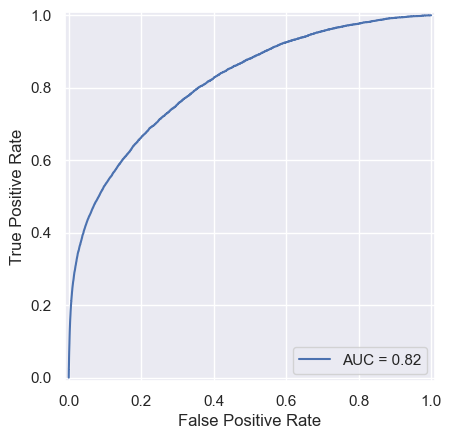

In [113]:
fpr, tpr, thresholds = metrics.roc_curve(predictions['label'], predictions['prediction'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

Text(0, 0.5, 'ROC AUC score (for that test set of size Step)')

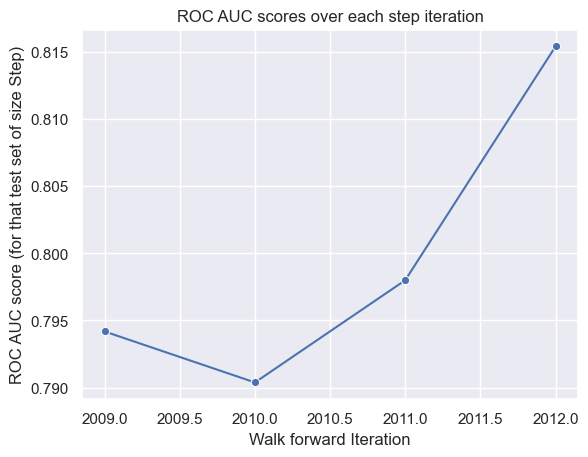

In [114]:
sns.lineplot(x=predictions['group'].unique(), y=stats_list, marker="o")
plt.title('ROC AUC scores over each step iteration')
plt.xlabel('Walk forward Iteration')
plt.ylabel('ROC AUC score (for that test set of size Step)')

In [115]:
default_data_viz = predictions.groupby('group')['label'].mean()

Text(0, 0.5, '% of defaults')

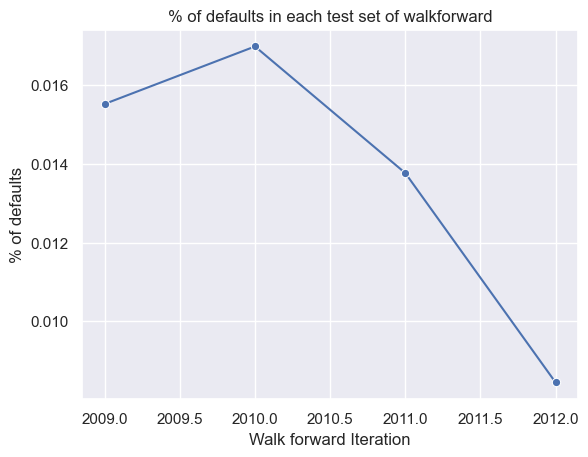

In [116]:
sns.lineplot(x=default_data_viz.index, y=default_data_viz, marker="o")
plt.title('% of defaults in each test set of walkforward')
plt.xlabel('Walk forward Iteration')
plt.ylabel('% of defaults')

In [77]:
stats_list[-1]

np.float64(0.8131164357402816)

In [72]:
last_model = model_list[-1]

In [75]:
last_model.rec_fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:               612920
Model:                          Logit   Df Residuals:                   612911
Method:                           MLE   Df Model:                            8
Date:                Tue, 12 Nov 2024   Pseudo R-squ.:                  0.1794
Time:                        19:51:24   Log-Likelihood:                -38797.
converged:                       True   LL-Null:                       -47280.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -7.0672      0.067   -105.408      0.000      -7.199      -6.936
financial_leverage_quantile_values      3.3452      0.189     17.688      0.000       2.975       3.716
profitability_ratio_quantile_values     4.7284      0.207     22.791      0.000       4.322       5.135
net_income_growth_quantile_values       5.5614      0.436     12.752      0.000       4.707       6.416
quick_ratio_v2_quantile_values         40.2202      2.190     18.364      0.000      35.928      44.513
sales_growth_quantile_values           21.7656      1.035     21.034      0.000      19.737      23.794
dscr_quantile_values                   17.7857      0.572     31.111      0.000      16.665      18.906
roe_quantile_values                    15.1294      0.405     37.375      0.000      14.336      15.923
regional_code_pd                       62.9039      3.895     16.150      0.000      55.270      70.538
=======================================================================================================
"""

In [74]:
last_model.first_fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:               224993
Model:                          Logit   Df Residuals:                   224986
Method:                           MLE   Df Model:                            6
Date:                Tue, 12 Nov 2024   Pseudo R-squ.:                  0.1072
Time:                        19:49:44   Log-Likelihood:                -11393.
converged:                       True   LL-Null:                       -12761.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -6.6438      0.124    -53.693      0.000      -6.886      -6.401
financial_leverage_quantile_values      4.2854      0.403     10.645      0.000       3.496       5.074
profitability_ratio_quantile_values     6.9056      0.439     15.739      0.000       6.046       7.766
quick_ratio_v2_quantile_values         34.9860      4.247      8.238      0.000      26.662      43.310
dscr_quantile_values                   13.7369      1.178     11.662      0.000      11.428      16.046
roe_quantile_values                    11.9757      0.764     15.680      0.000      10.479      13.473
regional_code_pd                       57.2127      7.346      7.789      0.000      42.816      71.610
=======================================================================================================
"""

In [76]:
224993+612920

837913

In [ ]:
metrics.roc_auc_score()

np.float64(0.8488916443372173)

In [117]:
for year in predictions['group'].unique():
    preds = predictions[predictions['group']==year]['prediction']
    true = predictions[predictions['group']==year]['label']
    print(year, metrics.roc_auc_score(y_true=true, y_score=preds))

2009.0 0.7941728719899361
2010.0 0.7881381112668416
2011.0 0.8115053950213774
2012.0 0.8514146316683037
